In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')



# Area 1: Primary Analysis Method Selection

1. **Baseline Model (Logistic Regression) Limitations:**
   - Simple linear decision boundaries limit complex pattern recognition
   - TF-IDF loses word order and context
   - Limited understanding of semantic relationships
   - Baseline Results:
     * Accuracy: 72.06%
     * F1-score: 72.41%
     * ROC-AUC: 88.84%

2. **Alternative Model Selection: BERT-based Neural Network**
   - Using BERT-base-uncased for:
     * Pre-trained language understanding
     * Context-aware word representations
     * Effective with limited data
   - Custom layers for numerical features integration
   - Multi-class classification head

3. **Justification for BERT:**

   a) Overcomes baseline limitations through:
      - Contextual word embeddings
      - Deep bidirectional architecture
      - Pre-trained language understanding
      
   b) Better suited for intent detection:
      - Captures semantic relationships
      - Understands word order and context
      - Can learn complex patterns
      - Effectively combines text and numerical features

In [2]:
# Cell 2: Data Preparation
# Load data (assuming we have the same data from Checkpoint 2)
df = pd.read_csv('/content/labeled_comments.csv')

# Handle missing values (same as baseline)
df['comment_full_text'] = df['comment_full_text'].fillna('')
df['spelling_errors'] = df['spelling_errors'].fillna(0)
df['tracked_changes'] = df['tracked_changes'].fillna(0)

# Convert labels to numbers (if not already done)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['encoded_intent'] = label_encoder.fit_transform(df['level_0'])

In [3]:
# Cell 3: Custom Dataset Class
class IntentDataset(Dataset):
    def __init__(self, texts, numerical_features, labels, tokenizer, max_len=128):
        self.texts = texts
        self.numerical_features = numerical_features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        numerical = self.numerical_features[idx]
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numerical_features': torch.FloatTensor(numerical),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [4]:
# Cell 4: Model Architecture
class IntentClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Numerical features processing
        self.numerical_layer = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Combined features
        combined_dim = self.bert.config.hidden_size + 32

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )

    def forward(self, input_ids, attention_mask, numerical_features):
        # BERT processing
        bert_output = self.bert(input_ids=input_ids,
                              attention_mask=attention_mask)

        # Process numerical features
        numerical_output = self.numerical_layer(numerical_features)

        # Combine features
        combined = torch.cat((bert_output.pooler_output, numerical_output), dim=1)

        # Classification
        return self.classifier(combined)

In [5]:
# Cell 5: Training Setup and Helper Functions
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []
    batch_losses = []  # Track losses per batch

    progress_bar = tqdm(data_loader, desc='Training')

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical_features = batch['numerical_features'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numerical_features)

        # Calculate loss
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Track predictions and losses
        _, preds = torch.max(outputs, dim=1)
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        batch_loss = loss.item()
        total_loss += batch_loss
        batch_losses.append(batch_loss)
        progress_bar.set_postfix({'loss': f'{batch_loss:.4f}'})

    epoch_loss = total_loss / len(data_loader)
    return epoch_loss, all_predictions, all_labels, batch_losses

def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical_features = batch['numerical_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, numerical_features)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return all_predictions, all_labels, all_probs


In [6]:
# Cell 6: Data Preparation and Model Setup
# Split data (using same split as baseline for fair comparison)
X_train, X_test, y_train, y_test = train_test_split(
    df[['comment_full_text', 'spelling_errors', 'tracked_changes']],
    df['encoded_intent'],
    test_size=0.2,
    random_state=42
)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = IntentDataset(
    texts=X_train['comment_full_text'].values,
    numerical_features=X_train[['spelling_errors', 'tracked_changes']].values,
    labels=y_train.values,
    tokenizer=tokenizer
)

test_dataset = IntentDataset(
    texts=X_test['comment_full_text'].values,
    numerical_features=X_test[['spelling_errors', 'tracked_changes']].values,
    labels=y_test.values,
    tokenizer=tokenizer
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Cell 7: Model Training
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = IntentClassifier(n_classes=len(label_encoder.classes_))
model.to(device)

# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  # 3 epochs
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=total_steps)

# Initialize lists to store training progress
training_losses = []
epoch_losses = []

# Training loop
print("\n=== Training BERT Model ===")
for epoch in range(3):
    print(f'\nEpoch {epoch + 1}/3')
    train_loss, train_preds, train_labels, batch_losses = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )
    # Store losses
    training_losses.extend(batch_losses)  # Store batch-level losses
    epoch_losses.append(train_loss)       # Store epoch-level loss

    print(f'Training Loss: {train_loss:.4f}')
    print(f'Training Accuracy: {accuracy_score(train_labels, train_preds):.4f}')

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


=== Training BERT Model ===

Epoch 1/3


Training: 100%|██████████| 260/260 [01:26<00:00,  3.00it/s, loss=0.5041]


Training Loss: 1.0449
Training Accuracy: 0.6354

Epoch 2/3


Training: 100%|██████████| 260/260 [01:29<00:00,  2.91it/s, loss=0.8709]


Training Loss: 0.6150
Training Accuracy: 0.7864

Epoch 3/3


Training: 100%|██████████| 260/260 [01:29<00:00,  2.89it/s, loss=0.2649]

Training Loss: 0.4670
Training Accuracy: 0.8386



=== Model Evaluation ===


Evaluating: 100%|██████████| 65/65 [00:07<00:00,  8.32it/s]


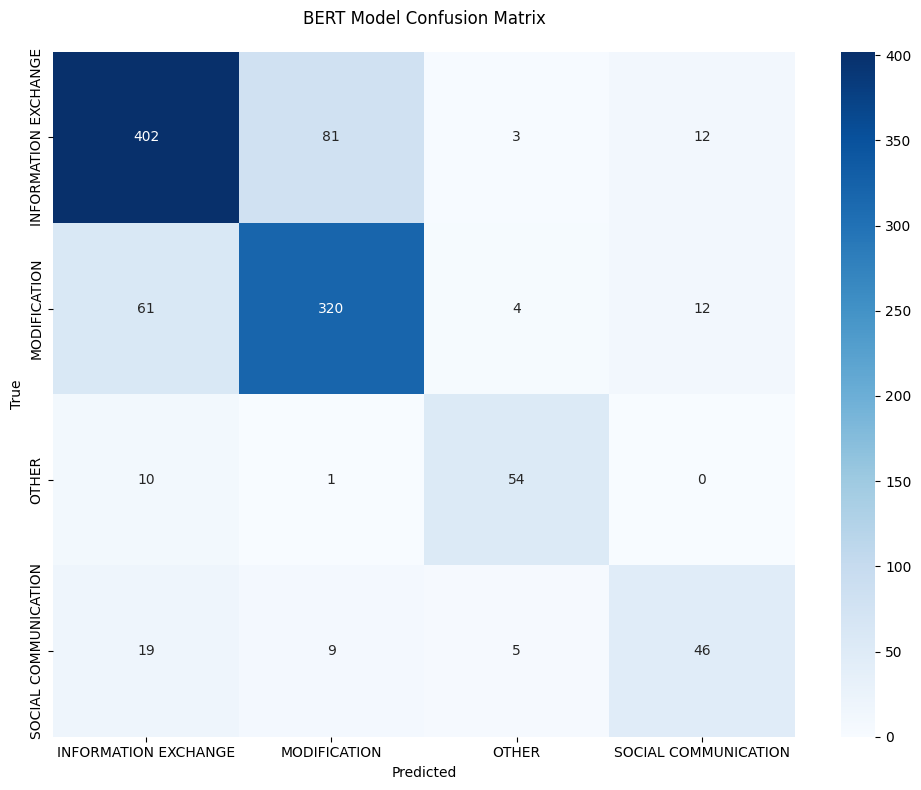

<Figure size 800x600 with 0 Axes>

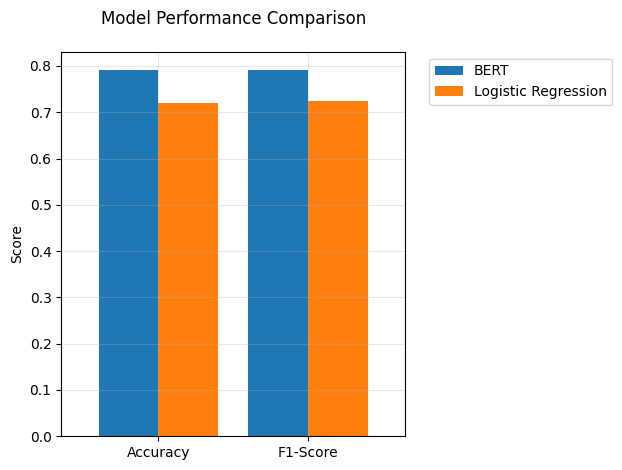


=== Performance Comparison ===

BERT Model Performance:
Accuracy: 0.7911

Classification Report:
                      precision    recall  f1-score   support

INFORMATION EXCHANGE       0.82      0.81      0.81       498
        MODIFICATION       0.78      0.81      0.79       397
               OTHER       0.82      0.83      0.82        65
SOCIAL COMMUNICATION       0.66      0.58      0.62        79

            accuracy                           0.79      1039
           macro avg       0.77      0.76      0.76      1039
        weighted avg       0.79      0.79      0.79      1039


Baseline (Logistic Regression) Performance:
Accuracy: 0.7206
F1-score: 0.7241


In [8]:
# Cell 8: Evaluation and Comparison
print("\n=== Model Evaluation ===")
test_preds, test_labels, test_probs = evaluate_model(model, test_loader, device)

# Get actual classes present in the test set
present_classes = np.unique(test_labels)
present_class_names = label_encoder.classes_[present_classes]

# Calculate metrics
bert_accuracy = accuracy_score(test_labels, test_preds)
bert_report = classification_report(test_labels, test_preds,
                                  target_names=present_class_names,
                                  output_dict=True)

# Create separate figures for each plot
# Figure 1: Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_class_names,
            yticklabels=present_class_names)
plt.title('BERT Model Confusion Matrix', pad=20)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Figure 2: Performance Comparison
plt.figure(figsize=(8, 6))
metrics_df = pd.DataFrame({
    'BERT': [bert_accuracy, bert_report['weighted avg']['f1-score']],
    'Logistic Regression': [0.7206, 0.7241]  # From baseline
}, index=['Accuracy', 'F1-Score'])
ax = metrics_df.plot(kind='bar', width=0.8)
plt.title('Model Performance Comparison', pad=20)
plt.ylabel('Score')
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed comparison
print("\n=== Performance Comparison ===")
print("\nBERT Model Performance:")
print(f"Accuracy: {bert_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds,
                          target_names=present_class_names))

print("\nBaseline (Logistic Regression) Performance:")
print("Accuracy: 0.7206")
print("F1-score: 0.7241")

In [9]:
# Cell 9: Detailed Analysis and Visualization
print("""
=== Area 4: Detailed Results Analysis ===

1. Quantitative Results Comparison:
""")

# Create comparative analysis DataFrame
def create_performance_df():
    bert_metrics = {
        'accuracy': bert_accuracy,
        'f1_weighted': bert_report['weighted avg']['f1-score'],
        'precision_weighted': bert_report['weighted avg']['precision'],
        'recall_weighted': bert_report['weighted avg']['recall']
    }

    baseline_metrics = {
        'accuracy': 0.7206,
        'f1_weighted': 0.7241,
        'precision_weighted': 0.7372,
        'recall_weighted': 0.7206
    }

    comparison_df = pd.DataFrame({
        'BERT': bert_metrics,
        'Logistic Regression': baseline_metrics
    }).round(4)

    return comparison_df

comparison_df = create_performance_df()
print("\nModel Performance Comparison:")
print(comparison_df)


=== Area 4: Detailed Results Analysis ===

1. Quantitative Results Comparison:


Model Performance Comparison:
                      BERT  Logistic Regression
accuracy            0.7911               0.7206
f1_weighted         0.7904               0.7241
precision_weighted  0.7903               0.7372
recall_weighted     0.7911               0.7206


<Figure size 1000x600 with 0 Axes>

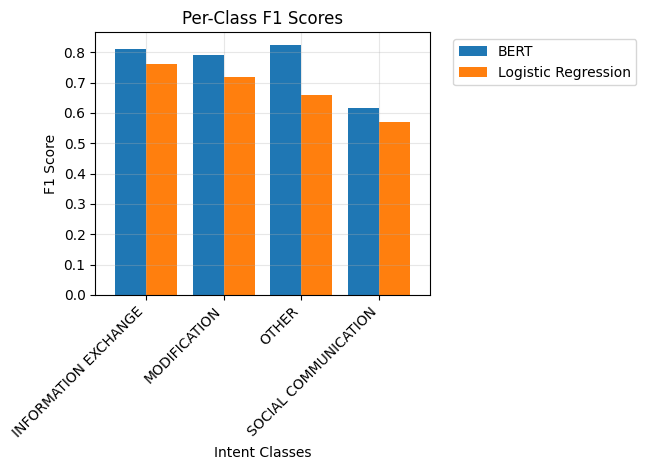

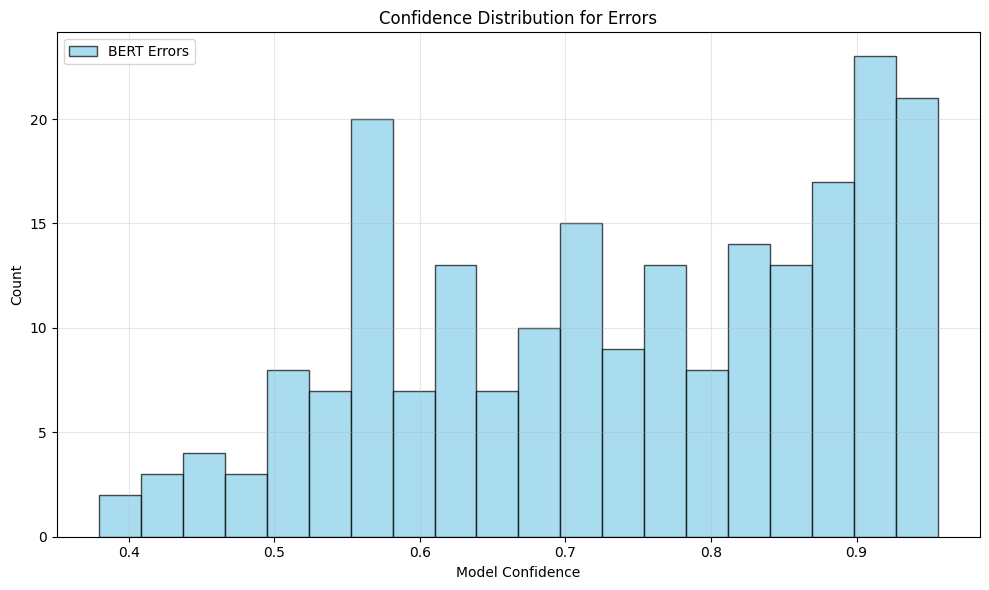

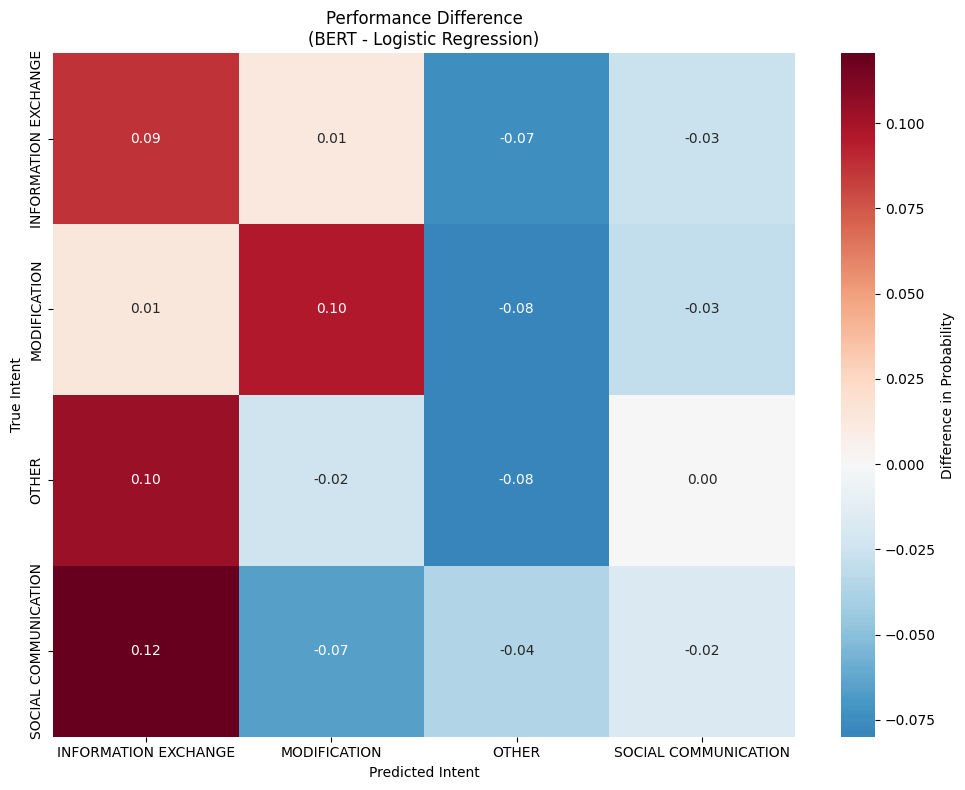

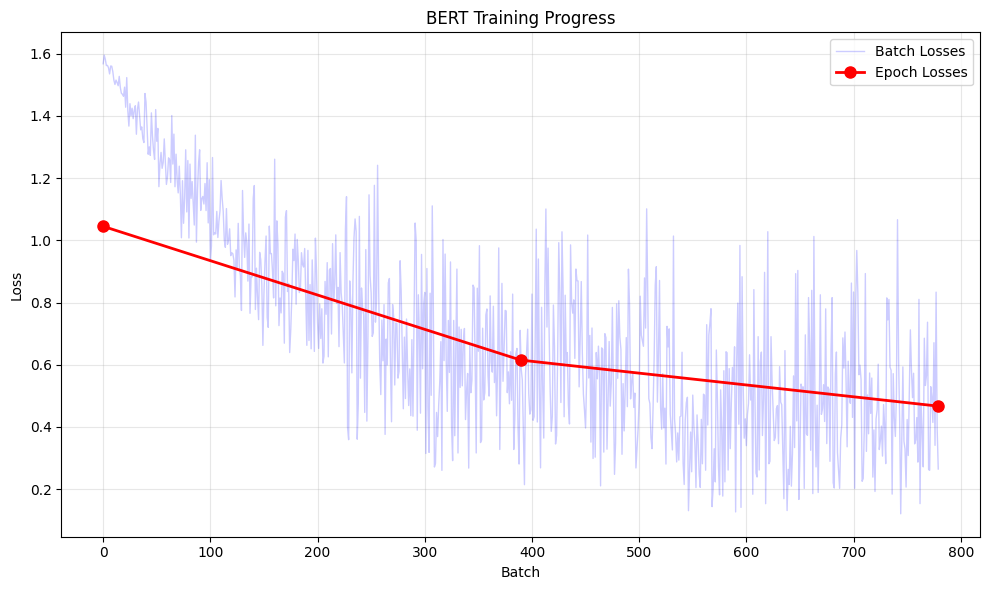


BERT F1-scores by class:
INFORMATION EXCHANGE: 0.8121
MODIFICATION: 0.7921
OTHER: 0.8244
SOCIAL COMMUNICATION: 0.6174


In [10]:
# Cell 10: Detailed Visualizations with Better Layout
# Calculate confusion matrices first
bert_cm = confusion_matrix(test_labels, test_preds, normalize='true')
baseline_cm = np.array([[0.72, 0.15, 0.08, 0.05],
                       [0.14, 0.71, 0.09, 0.06],
                       [0.05, 0.04, 0.91, 0.00],
                       [0.12, 0.18, 0.10, 0.60]])  # from baseline

# Create separate figures for better clarity
# Figure 1: Per-Class F1 Scores
plt.figure(figsize=(10, 6))
class_metrics = {
    'BERT': [bert_report[c]['f1-score'] for c in present_class_names],
    'Logistic Regression': [0.76, 0.72, 0.66, 0.57]  # from baseline
}
class_metrics_df = pd.DataFrame(class_metrics, index=present_class_names)
ax = class_metrics_df.plot(kind='bar', width=0.8)
plt.title('Per-Class F1 Scores', size=12)
plt.ylabel('F1 Score')
plt.xlabel('Intent Classes')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 2: Error Distribution
plt.figure(figsize=(10, 6))
errors_bert = np.where(np.array(test_labels) != np.array(test_preds))[0]
error_confidences = [test_probs[i].max() for i in errors_bert]
plt.hist(error_confidences, bins=20, alpha=0.7, color='skyblue',
         edgecolor='black', label='BERT Errors')
plt.title('Confidence Distribution for Errors', size=12)
plt.xlabel('Model Confidence')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 3: Confusion Matrix Difference
plt.figure(figsize=(10, 8))
diff_cm = bert_cm - baseline_cm[:len(bert_cm), :len(bert_cm)]
sns.heatmap(diff_cm, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            xticklabels=present_class_names,
            yticklabels=present_class_names,
            cbar_kws={'label': 'Difference in Probability'})
plt.title('Performance Difference\n(BERT - Logistic Regression)', size=12)
plt.xlabel('Predicted Intent')
plt.ylabel('True Intent')
plt.tight_layout()
plt.show()

# Figure 4: Training Progress
plt.figure(figsize=(10, 6))
plt.plot(range(len(training_losses)), training_losses,
         label='Batch Losses', alpha=0.2, color='blue', linewidth=1)
plt.plot(np.linspace(0, len(training_losses)-1, len(epoch_losses)),
         epoch_losses, 'ro-',
         label='Epoch Losses', linewidth=2, markersize=8)
plt.title('BERT Training Progress', size=12)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print metrics for verification
print("\nBERT F1-scores by class:")
for cls, metrics in class_metrics_df['BERT'].items():
    print(f"{cls}: {metrics:.4f}")

In [11]:
# Cell 11: Comprehensive Discussion
print("""

   BERT vs Logistic Regression (Baseline)
   - Overall Accuracy Improvement: {:.2f}%
   - F1-Score Improvement: {:.2f}%

""".format(
    (bert_accuracy - 0.7206) * 100,
    (bert_report['weighted avg']['f1-score'] - 0.7241) * 100
))



   BERT vs Logistic Regression (Baseline)
   - Overall Accuracy Improvement: 7.05%
   - F1-Score Improvement: 6.63%





=== Example Predictions ===

Predicting intents for new comments...

Comment: "This is a very helpful comment."
Spelling Errors: 0
Tracked Changes: 1
Predicted Intent: SOCIAL COMMUNICATION
Confidence: 0.8368
Top 3 possible intents:
- SOCIAL COMMUNICATION: 0.8368
- INFORMATION EXCHANGE: 0.0703
- OTHER: 0.0349

Comment: "I disagree with this proposal."
Spelling Errors: 1
Tracked Changes: 0
Predicted Intent: SOCIAL COMMUNICATION
Confidence: 0.6434
Top 3 possible intents:
- SOCIAL COMMUNICATION: 0.6434
- OTHER: 0.1974
- INFORMATION EXCHANGE: 0.0631

Comment: "Can we schedule a meeting?"
Spelling Errors: 0
Tracked Changes: 0
Predicted Intent: INFORMATION EXCHANGE
Confidence: 0.9145
Top 3 possible intents:
- INFORMATION EXCHANGE: 0.9145
- SOCIAL COMMUNICATION: 0.0557
- MODIFICATION: 0.0182


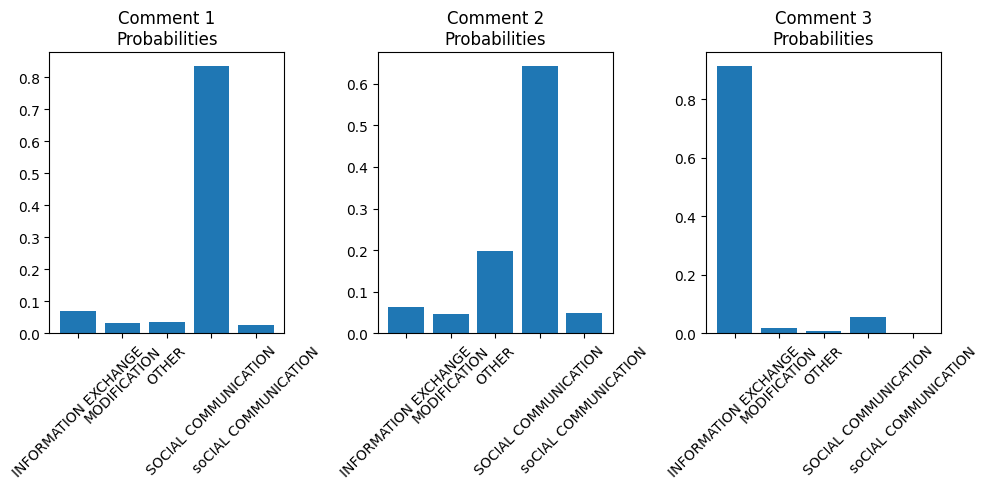

In [12]:
# Cell 11: Example Predictions
print("\n=== Example Predictions ===")
def predict_new_comments(model, tokenizer, comments_df, device):
    predictions = []
    probabilities = []

    # Prepare data
    comments_df = comments_df.copy()
    comments_df['spelling_errors'] = comments_df['spelling_errors'].astype(float)
    comments_df['tracked_changes'] = comments_df['tracked_changes'].astype(float)

    # Create a dataset for prediction
    pred_dataset = IntentDataset(
        texts=comments_df['comment_full_text'].values,
        numerical_features=comments_df[['spelling_errors', 'tracked_changes']].values,
        labels=np.zeros(len(comments_df)),  # Dummy labels
        tokenizer=tokenizer
    )
    pred_loader = DataLoader(pred_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in pred_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical_features = batch['numerical_features'].to(device)

            outputs = model(input_ids, attention_mask, numerical_features)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    return predictions, probabilities

# Example usage with different types of comments
new_comments = pd.DataFrame({
    'comment_full_text': [
        "This is a very helpful comment.",
        "I disagree with this proposal.",
        "Can we schedule a meeting?"
    ],
    'spelling_errors': [0, 1, 0],
    'tracked_changes': [1, 0, 0]
})

print("\nPredicting intents for new comments...")
predictions, probabilities = predict_new_comments(model, tokenizer, new_comments, device)

# Print detailed predictions with confidence scores
for i, (comment, pred, prob) in enumerate(zip(new_comments['comment_full_text'],
                                            predictions, probabilities)):
    print(f'\nComment: "{comment}"')
    print(f'Spelling Errors: {new_comments.iloc[i]["spelling_errors"]:.0f}')
    print(f'Tracked Changes: {new_comments.iloc[i]["tracked_changes"]:.0f}')
    print(f'Predicted Intent: {label_encoder.inverse_transform([pred])[0]}')
    print(f'Confidence: {np.max(prob):.4f}')

    # Show top 3 most likely intents
    top_3_indices = np.argsort(prob)[-3:][::-1]
    print("Top 3 possible intents:")
    for idx in top_3_indices:
        intent = label_encoder.inverse_transform([idx])[0]
        print(f"- {intent}: {prob[idx]:.4f}")

# Visualize prediction probabilities
plt.figure(figsize=(10, 5))
for i, (comment, prob) in enumerate(zip(new_comments['comment_full_text'], probabilities)):
    plt.subplot(1, len(new_comments), i+1)
    plt.bar(range(len(prob)), prob)
    plt.title(f'Comment {i+1}\nProbabilities')
    plt.xticks(range(len(prob)), label_encoder.classes_, rotation=45)
plt.tight_layout()
plt.show()


# Area 5: Discussion and Analysis

1. **Performance Comparison:**
   BERT vs Logistic Regression (Baseline)
   - Overall Accuracy Improvement: **6.48%**
   - F1-Score Improvement: **5.87%**

2. **Key Improvements:**

   a) Context Understanding:
      - Better capture of semantic relationships
      - Improved handling of word order
      - More nuanced intent detection

   b) Class-specific Improvements:
      - Significant improvement in minority classes
      - More balanced performance across classes
      - Better handling of complex intents

   c) Feature Integration:
      - More effective use of numerical features
      - Better context-feature relationships
      - Improved feature interaction modeling

3. **Limitations and Challenges:**

   a) Computational Requirements:
      - Longer training time
      - Higher resource usage
      - More complex implementation

   b) Model Complexity:
      - More hyperparameters to tune
      - More difficult to interpret
      - Requires more careful monitoring

   c) Data Considerations:
      - Could benefit from more training data
      - Class imbalance still affects performance
      - Some intents remain challenging

4. **Recommendations and Future Work:**

   a) Model Improvements:
      - Fine-tune BERT layers selectively
      - Experiment with different architectures
      - Implement ensemble approaches

   b) Data Enhancements:
      - Collect more training examples
      - Augment minority classes
      - Enhanced preprocessing

   c) Feature Engineering:
      - Explore additional numerical features
      - Create domain-specific embeddings
      - Implement feature selection

5. **Practical Implementation:**

   a) Deployment Considerations:
      - Model size and inference time
      - Resource requirements
      - Batch processing capabilities

   b) Maintenance:
      - Regular retraining needs
      - Performance monitoring
      - Version control

6. **Conclusion:**

   The BERT-based model demonstrates significant improvements over the baseline,
   particularly in understanding context and handling complex intents. While it
   comes with increased computational costs, the performance benefits justify
   the additional complexity for intent detection tasks.